In [ ]:
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
from google.colab import files
from numpy import diff
from scipy import integrate
import time
Lx,Lz = 2000,2000                                   # Space in x and y direction, 2000m
Nx = 201                                            # Grid points in x direction
Nz = 201                                            # Grid points in z direction
tol = 1e-7                                          # Tolerance = 10^-7
dx = Lx/(Nx-1)
dz = Lz/(Nz-1)
x0,z0 = Lx/2,260                                # Initial position for first buffle
T_tot = 900                                         # T_total = 620 seconds
tau = 8 * 1e-5                                      # Tau/pi*a^2 = 8 x 10 ^ -5
theta_0 = 300.0                                       # Initial Temperature
delta_theta = 0.5                                   # Delta in temperature
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
x_mesh,z_mesh = np.meshgrid(x,z)
r0 = 250
g = 9.81



velocity = (2*r0*g*delta_theta/theta_0)**(1/2)              #Velocity of the bubble rising up 
time_scale = r0/velocity                                    #Time scale
print(time_scale*0.06)
delta_t = 0.25;                                              # satisfy v*dt/dx as dx/velocity = 6.99 with delta t = 5s to keep our courant number from potentially going over 1.
v_art = 2*r0*velocity / 1500                                #Artificial viscosity
diffusivity = v_art                                         #diffusivity

5.246230625870018


In [ ]:
def init_temperature(x, z, x0, z0, r0, theta_0, delta_theta):
    distance = np.sqrt((x - x0)**2 + (z - z0)**2)
    condition = distance <= r0
    temperature = np.where(condition, theta_0 + delta_theta, theta_0)
    return temperature

In [ ]:
def SOR_opt(dx,dz):
  sigma = (1/(1+(dx/dz)**2))*((math.cos(math.pi/Nx)+((dx/dz)**2))*(math.cos(math.pi/Nz)))
  return 2/(1+math.sqrt(1-sigma**2))

print(SOR_opt(dx,dz))

1.9624368520008746


In [ ]:
def plot_cmap(np_array, Title):
    plt.figure()
    plt.imshow(np_array, cmap='bwr', vmin=np.min(np_array), vmax=np.max(np_array))
    plt.gca().invert_yaxis()  # Invert y-axis
    plt.colorbar()
    plt.title(Title)


In [ ]:

vort_super = np.zeros([Nz+2,Nx+2])                                  # Setup vorticity field with periodic boundary conditions for x and walls for z
init_temp = np.zeros([Nz+2,Nx+2])
init_temp[1:Nz+1,1:Nx+1] = init_temperature(x_mesh,z_mesh,x0,z0,r0,theta_0,delta_theta) #intialize temperature field array

init_temp[:,0] = init_temp[:,Nx-1]
init_temp[:,Nx+1] = init_temp[:,2]
init_temp[1,:] = theta_0
init_temp[Nz,:] = theta_0

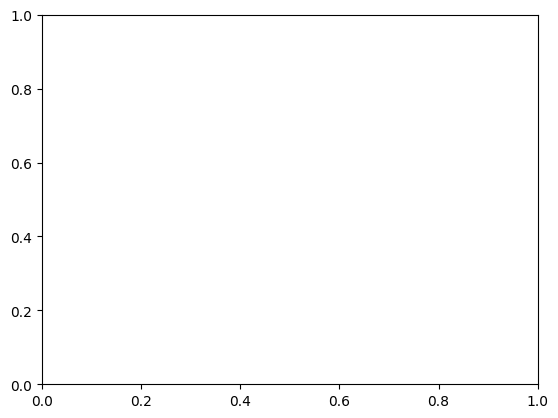

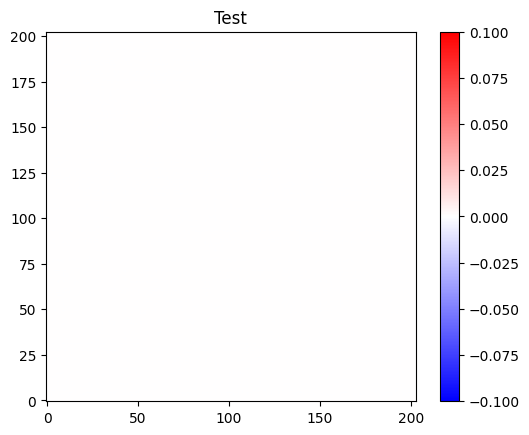

In [ ]:

fig, ax = plt.subplots()
plot_cmap(vort_super,"Test")

def animate(frame, u,t_delta):
    ax.clear()
    ax.imshow(u[frame, :, :], origin='lower', extent=[0, Lx, 0, Lz])
    ax.set_title("Vorticitz at time step: {0:.2f} seconds".format(frame * t_delta))
    ax.set_xlim(0,Lx)
    ax.set_ylim(0,Lz)
    ax.set_xlabel("X in km")
    ax.set_ylabel("z in km")

In [ ]:


def infinite_norm(matrix):
    return np.max(np.abs(matrix))

def one_norm(matrix):
    return np.sum(np.abs(matrix))

e_dxdz = 2/dx/dx + 2/dz/dz

def error(psi,vort,res):
  psi_one_norm = one_norm(psi)
  res_inf_norm = infinite_norm(res)
  vort_inf_norm = infinite_norm(vort)

  EPS = res_inf_norm /((e_dxdz)*psi_one_norm + vort_inf_norm)
  return EPS

In [ ]:
def SOR(vort):
  psi = np.zeros([Nz+2,Nx+2])
  residual = np.zeros([Nz+2,Nx+2])
  u = np.zeros([Nz+2,Nx+2])
  v = np.zeros([Nz+2,Nx+2])
  coef = SOR_opt(dx,dz)

  for j in range(2,Nz):
    for i in range(1,Nx+1):
        residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
        + 1/dz/dz *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) + vort[j,i]
  

  # residual[1:Nz+1,1:Nx+1] =  1/dx/dx *(psi[0:Nz,1:Nx+1] - 2*psi[1:Nz+1,1:Nx+1] + psi[2:Nz+2,1:Nx+1]) \
  # + 1/dz/dz * (psi[1:Nz+1,0:Nx]-2*psi[1:Nz+1,1:Nx+1]+psi[1:Nz+1,2:Nx+2]) + vort[1:Nz+1,1:Nx+1] 

  residual[1,:] = 0;
  residual[Nz,:] = 0;
  residual[:,0] = residual[:,Nx-1]
  residual[:,Nx+1] = residual[:,2] 

  EPS = error(psi,vort,residual)
  num_iterations = 0
  EPS_arr = []
  EPS_arr.append(EPS)
  while(EPS >= tol):
    for j in range(2,Nz):
      for i in range(1,Nx+1):
        if(i == Nx):
          #update ghost nodes at Nx+1 at current j
          residual[j,Nx+1] = residual[j,2]
          psi[j,Nx+1] = psi[j,2]

        residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
        + 1/dz/dz *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) + vort[j,i]

        psi[j,i] = psi[j,i] + coef/(e_dxdz) * residual[j,i]  #Remember to subsititute 1 with optimal value of sigma
      
      #update ghost nodes at i = 0 at current j
      residual[j,0] = residual[j,Nx-1]
      psi[j,0] = psi[j,Nx-1]
      
    EPS = error(psi,vort,residual)
    num_iterations += 1
    EPS_arr.append(EPS)
  print("Number of poisson iterations: {}".format(num_iterations))
  # print(psi.shape)

  #calculate u and v bz differentating psi with respect to dz and dx
  # u, v = np.gradient(psi, dz, dx)
  u = np.gradient(psi,dz,axis = 0)
  v = np.gradient(psi,dx,axis = 1)
  # Multiplz d_psi_dz bz -1 to get the negative of the derivative
  u *= -1


  # Compute the Laplacian (∇²psi) using numerical differentiation
  d2_psi_dx2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dx**2
  d2_psi_dz2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dz**2

  laplacian_psi = d2_psi_dx2 + d2_psi_dz2

  return psi,u,v,num_iterations,laplacian_psi

In [ ]:
def SOR_psi(psi,vort):
  residual = np.zeros([Nz+2,Nx+2])
  u = np.zeros([Nz+2,Nx+2])
  v = np.zeros([Nz+2,Nx+2])
  coef = SOR_opt(dx,dz)

  for j in range(2,Nz):
      for i in range(1,Nx+1):
        residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
        + 1/dz/dz *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) + vort[j,i]

  # residual[1:Nz+1,1:Nx+1] =  1/dx/dx *(psi[0:Nz,1:Nx+1] - 2*psi[1:Nz+1,1:Nx+1] + psi[2:Nz+2,1:Nx+1]) \
  # + 1/dz/dz * (psi[1:Nz+1,0:Nx]-2*psi[1:Nz+1,1:Nx+1]+psi[1:Nz+1,2:Nx+2]) + vort[1:Nz+1,1:Nx+1] 

  residual[1,:] = 0;
  residual[Nz,:] = 0;
  residual[:,0] = residual[:,Nx-1]
  residual[:,Nx+1] = residual[:,2]

  EPS = error(psi,vort,residual)
  num_iterations = 0
  EPS_arr = []
  EPS_arr.append(EPS)
  while(EPS >= tol):
    for j in range(2,Nz):
      for i in range(1,Nx+1):
        if(i == Nx):
          #update ghost nodes at Nx+1 at current j
          residual[j,Nx+1] = residual[j,2]
          psi[j,Nx+1] = psi[j,2]

        residual[j,i] = 1/dx/dx * (psi[j-1,i] - 2*psi[j,i] + psi[j+1,i]) \
        + 1/dz/dz *(psi[j,i-1] - 2 * psi[j,i] + psi[j,i+1]) + vort[j,i]

        psi[j,i] = psi[j,i] + coef/(e_dxdz) * residual[j,i]  #Remember to subsititute 1 with optimal value of sigma
      
      #update ghost nodes at i = 0 at current j
      residual[j,0] = residual[j,Nx-1]
      psi[j,0] = psi[j,Nx-1]

    # print(EPS)
    EPS = error(psi,vort,residual)
    num_iterations += 1
    EPS_arr.append(EPS)
  print(num_iterations)
  # print(psi.shape)

  #calculate u and v bz differentating psi with respect to dz and dx
  # u, v = np.gradient(psi, dz, dx)
  u = np.gradient(psi,dz,axis = 0)
  v = np.gradient(psi,dx,axis = 1)
  # Multiplz d_psi_dz bz -1 to get the negative of the derivative
  u *= -1


  # Compute the Laplacian (∇²psi) using numerical differentiation
  d2_psi_dx2 = np.gradient(np.gradient(psi, axis=1), axis=1) / dx**2
  d2_psi_dz2 = np.gradient(np.gradient(psi, axis=0), axis=0) / dz**2

  laplacian_psi = d2_psi_dx2 + d2_psi_dz2

  return psi,u,v,num_iterations,laplacian_psi

In [ ]:

psi,u,v,num_iterations,laplacian_psi = SOR(vort_super)
print(psi[0,:])
Mg = np.sqrt(u**2+v**2)

ktot = lambda z,x :0.5*np.sqrt(u**2+v**2)**2
def ktot(u,v):
  return 0.5*np.sqrt(u**2+v**2)**2

def double_Integral(xmin, xmax, zmin, zmax, nx, nz, A):

    dS = ((xmax-xmin)/(nx-1)) * ((zmax-zmin)/(nz-1))

    A_Internal = A[1:-1, 1:-1]

    # sides: up, down, left, right
    (A_u, A_d, A_l, A_r) = (A[0, 1:-1], A[-1, 1:-1], A[1:-1, 0], A[1:-1, -1])

    # corners
    (A_ul, A_ur, A_dl, A_dr) = (A[0, 0], A[0, -1], A[-1, 0], A[-1, -1])

    return dS * (np.sum(A_Internal)\
                + 0.5 * (np.sum(A_u) + np.sum(A_d) + np.sum(A_l) + np.sum(A_r))\
                + 0.25 * (A_ul + A_ur + A_dl + A_dr))


# Derived from doing max(u/dx + v/dz) 
def courant_max(u,v,delta_t):
  return np.max(u*delta_t/dx + v*delta_t/dz)


Number of poisson iterations: 0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


<ipython-input-32-bb1e4380f924>:14: RuntimeWarning: invalid value encountered in double_scalars
  EPS = res_inf_norm /((e_dxdz)*psi_one_norm + vort_inf_norm)


In [ ]:
def Arakawa_desc(psi,vort,temp):
  J_arakawa_vort = np.zeros([Nz+2,Nx+2])
  J_arakawa_temp = np.zeros([Nz+2,Nx+2])

  J = np.zeros([Nz+2,Nx+2])
  J_hat = np.zeros([Nz+2,Nx+2])
  J_tilda = np.zeros([Nz+2,Nx+2])

  J_temp = np.zeros([Nz+2,Nx+2])
  J_hat_temp = np.zeros([Nz+2,Nx+2])
  J_tilda_temp = np.zeros([Nz+2,Nx+2])
  # for i in range(1,N)
  for z in range(2,Nz):
    for i in range(1,Nx+1):

      J[z,i] = (1/(4*dx*dz))*((psi[z,i+1] - psi[z,i-1]) * (vort[z+1,i] - vort[z-1,i])
      - (psi[z+1,i] - psi[z-1,i]) * (vort[z,i+1] - vort[z,i-1]))
      
      J_hat[z,i] = (1/(4*dx*dz))* (((psi[z,i+1])*(vort[z+1,i+1] - vort[z-1,i+1])) \
      - ((psi[z,i-1])*(vort[z+1,i-1] - vort[z-1,i-1]))  \
      - ((psi[z+1,i])*(vort[z+1,i+1] - vort[z+1,i-1]))  \
      + ((psi[z-1,i])*(vort[z-1,i+1] - vort[z-1,i-1]))) 
    
      J_tilda[z,i] = (1/(4*dx*dz))* (((vort[z+1,i])*(psi[z+1,i+1] - psi[z+1,i-1])) \
      - ((vort[z-1,i])*(psi[z-1,i+1] - psi[z-1,i-1]))  \
      - ((vort[z,i+1])*(psi[z+1,i+1] - psi[z-1,i+1]))  \
      + ((vort[z,i-1])*(psi[z+1,i-1] - psi[z-1,i-1]))) 

      # J_arakawa_vort = (J + J_hat + J_tilda)/3


      J_temp[z,i] = (1/(4*dx*dz))*((psi[z,i+1] - psi[z,i-1]) * (temp[z+1,i] - temp[z-1,i])
      - (psi[z+1,i] - psi[z-1,i]) * (temp[z,i+1] - temp[z,i-1]))
      
      J_hat_temp[z,i] = (1/(4*dx*dz))* (((psi[z,i+1])*(temp[z+1,i+1] - temp[z-1,i+1])) \
      - ((psi[z,i-1])*(temp[z+1,i-1] - temp[z-1,i-1]))  \
      - ((psi[z+1,i])*(temp[z+1,i+1] - temp[z+1,i-1]))  \
      + ((psi[z-1,i])*(temp[z-1,i+1] - temp[z-1,i-1]))) 
    
      J_tilda_temp[z,i] = (1/(4*dx*dz))* (((temp[z+1,i])*(psi[z+1,i+1] - psi[z+1,i-1])) \
      - ((temp[z-1,i])*(psi[z-1,i+1] - psi[z-1,i-1]))  \
      - ((temp[z,i+1])*(psi[z+1,i+1] - psi[z-1,i+1]))  \
      + ((temp[z,i-1])*(psi[z+1,i-1] - psi[z-1,i-1]))) 
      
  J_arakawa_vort = (J + J_hat + J_tilda) / 3
  J_arakawa_temp = (J_temp + J_hat_temp + J_tilda_temp)/3

  return J_arakawa_vort,J_arakawa_temp


In [ ]:

def Calc_Bubble(t_delta,init_vort,init_temp):
  t_steps = int(T_tot/t_delta)
  psi,u,v,num_iterations,laplacian_psi=SOR(init_vort)
  vort = np.zeros([t_steps,Nz+2,Nx+2])
  temp = np.zeros([t_steps,Nz+2,Nx+2])
  vort[0,:,:] = init_vort
  temp[0,:,:] = init_temp

  C_max_arr = []
  num_iterations_arr = []
  temp_arr = []

  d2_vort_dx2 = np.gradient(np.gradient(vort[0,:,:], axis=1), axis=1) / dx**2
  d2_vort_dz2 = np.gradient(np.gradient(vort[0,:,:], axis=0), axis=0) / dz**2

  laplacian_vort = d2_vort_dx2 + d2_vort_dz2


  d2_temp_dx2 = np.gradient(np.gradient(temp[0,:,:], axis=1), axis=1) / dx**2
  d2_temp_dz2 = np.gradient(np.gradient(temp[0,:,:], axis=0), axis=0) / dz**2

  laplacian_temp = d2_vort_dx2 + d2_vort_dz2
  
  #Append num_iterations
  num_iterations_arr.append(num_iterations)

  #Calculate Von Neumann
  C_max = courant_max(u,v,t_delta)
  C_max_arr.append(C_max)
  print("Von Neumman:{}".format(C_max))

  #Calculate temperature conservation
  temp_tot = double_Integral(0, 2000, 0, 2000, Nx, Nz, temp[0,:,:])
  temp_arr.append(temp_tot)
  print("Conservation of temperature:{}".format(temp_tot))

  #Calculate new vorticity using FTCS for first time step using implied loops from 1 to Nx-1 and 1 to Nz-1 grid points

  J_arakawa_vort = np.zeros([Nz+2,Nx+2])
  J_arakawa_temp = np.zeros([Nz+2,Nx+2])

  J = (1/(4*dx*dz))*((psi[1:Nz+1,2:Nx+2] - psi[1:Nz+1,0:Nx]) * (vort[0,2:Nz+2,1:Nx+1] - vort[0,0:Nz,1:Nx+1])
  - (psi[2:Nz+2,1:Nx+1] - psi[0:Nz,1:Nx+1]) * (vort[0,1:Nz+1,2:Nx+2] - vort[0,1:Nz+1,0:Nx]))
  
  J_hat = (1/(4*dx*dz))* (((psi[1:Nz+1,2:Nx+2])*(vort[0,2:Nz+2,2:Nx+2] - vort[0,0:Nz,2:Nx+2])) \
  - ((psi[1:Nz+1,0:Nx])*(vort[0,2:Nz+2,0:Nx] - vort[0,0:Nz,0:Nx]))  \
  - ((psi[2:Nz+2,1:Nx+1])*(vort[0,2:Nz+2,2:Nx+2] - vort[0,2:Nz+2,0:Nx]))  \
  + ((psi[0:Nz,1:Nx+1])*(vort[0,0:Nz,2:Nx+2] - vort[0,0:Nz,0:Nx]))) 
 
  J_tilda = (1/(4*dx*dz))* (((vort[0,2:Nz+2,1:Nx+1])*(psi[2:Nz+2,2:Nx+2] - psi[2:Nz+2,0:Nx])) \
  - ((vort[0,0:Nz,1:Nx+1])*(psi[0:Nz,2:Nx+2] - psi[0:Nz,0:Nx]))  \
  - ((vort[0,1:Nz+1,2:Nx+2])*(psi[2:Nz+2,2:Nx+2] - psi[0:Nz,2:Nx+2]))  \
  + ((vort[0,1:Nz+1,0:Nx])*(psi[2:Nz+2,0:Nx] - psi[0:Nz,0:Nx]))) 


  J_arakawa_vort[1:Nz+1,1:Nx+1] = (J + J_hat + J_tilda) / 3

  J_temp = (1/(4*dx*dz))*((psi[1:Nz+1,2:Nz+2] - psi[1:Nz+1,0:Nx]) * (temp[0,2:Nz+2,1:Nx+1] - temp[0,0:Nz,1:Nx+1])
  - (psi[2:Nz+2,1:Nx+1] - psi[0:Nz,1:Nx+1]) * (temp[0,1:Nz+1,2:Nx+2] - temp[0,1:Nz+1,0:Nx]))
  
  J_hat_temp = (1/(4*dx*dz))* (((psi[1:Nz+1,2:Nx+2])*(temp[0,2:Nz+2,2:Nx+2] - temp[0,0:Nz,2:Nx+2])) \
  - ((psi[1:Nz+1,0:Nx])*(temp[0,2:Nz+2,0:Nx] - temp[0,0:Nz,0:Nx]))  \
  - ((psi[2:Nz+2,1:Nx+1])*(temp[0,2:Nz+2,2:Nx+2] - temp[0,2:Nz+2,0:Nx]))  \
  + ((psi[0:Nz,1:Nx+1])*(temp[0,0:Nz,2:Nx+2] - temp[0,0:Nz,0:Nx]))) 
 
  J_tilda_temp = (1/(4*dx*dz))* (((temp[0,2:Nz+2,1:Nx+1])*(psi[2:Nz+2,2:Nx+2] - psi[2:Nz+2,0:Nx])) \
  - ((temp[0,0:Nz,1:Nx+1])*(psi[0:Nz,2:Nx+2] - psi[0:Nz,0:Nx]))  \
  - ((temp[0,1:Nz+1,2:Nx+2])*(psi[2:Nz+2,2:Nx+2] - psi[0:Nz,2:Nx+2]))  \
  + ((temp[0,1:Nz+1,0:Nx])*(psi[2:Nz+2,0:Nx] - psi[0:Nz,0:Nx]))) 
  
  J_arakawa_temp[1:Nz+1,1:Nx+1] = (J_temp + J_hat_temp + J_tilda_temp)/3

  # J_arakawa_vort,J_arakawa_temp = Arakawa_desc(psi,vort[0,:,:],temp[0,:,:])
  # print(psi)
  # print(vort[0,:,:])
  # print(np)
  temp[1,2:Nz,1:Nx+1] = temp[0,2:Nz,1:Nx+1] - (2*t_delta)*J_arakawa_temp[2:Nz,1:Nx+1]#- diffusivity*(laplacian_temp)

  
  temp[1,:,0] = temp[1,:,Nx-1]
  temp[1,:,Nx+1] = temp[1,:,2]
  temp[1,1,:] = theta_0
  temp[1,Nz,:] = theta_0
  # temp[1,0,:] = 0
  # temp[1,Nz+1,:] = 0

  d_theta_dx = (temp[0,2:Nz,2:Nx+2] - temp[0,2:Nz,0:Nx])/(2*dx)
  vort[1,2:Nz,1:Nx+1] = vort[0,2:Nz,1:Nx+1] + (2*t_delta)*(-J_arakawa_vort[2:Nz,1:Nx+1] - (g/theta_0)*(d_theta_dx) + v_art*(laplacian_vort[2:Nz,1:Nx+1]))
  
  # d_theta_dx = (temp[0,2:Nz,3:Nx+1] - temp[0,2:Nz,1:Nx-1])/(2*dx)
  # vort[1,2:Nz,2:Nx] = vort[0,2:Nz,2:Nx] + (2*t_delta)*(-J_arakawa_vort[1:Nx-1,1:Nz-1] - (g/theta_0)*(d_theta_dx) + v_art*(laplacian_vort[2:Nz,2:Nx]))

  #Applz boundarz conditions for the new vorticitz field
  vort[1,1,:] = 0
  vort[1,Nz+1,:] = 0

  vort[1,:,0] = vort[1,:,Nx-1]
  vort[1,:,Nx+1] = vort[1,:,2]
  # vort[1,0,:] = 0
  # vort[1,Nz+1,:] = 0
  
  #Use the poisson solver again to compute psi,u,v
  psi,u,v,num_iterations,laplacian_psi = SOR_psi(psi,vort[1,:,:])


  #Append num_iterations
  num_iterations_arr.append(num_iterations)

  #Calculate Von Neumann
  C_max = courant_max(u,v,t_delta)
  C_max_arr.append(C_max)
  print("Von Neumman:{}".format(C_max))


  #Calculate temperature conservation
  temp_tot = double_Integral(0, 2000, 0, 2000, Nx, Nz, temp[1,:,:])
  temp_arr.append(temp_tot)
  print("Conservation of temperature:{}".format(temp_tot))
  
  #Calculate new vorticitz using CTCS for everz time step using implied loops from 1 to Nx-1 and 1 to Nz-1 grid points
  for n in range(1,t_steps-1):
    

    d2_vort_dx2 = np.gradient(np.gradient(vort[n,:,:], axis=1), axis=1) / dx**2
    d2_vort_dz2 = np.gradient(np.gradient(vort[n,:,:], axis=0), axis=0) / dz**2

    laplacian_vort = d2_vort_dx2 + d2_vort_dz2


    d2_temp_dx2 = np.gradient(np.gradient(temp[n,:,:], axis=1), axis=1) / dx**2
    d2_temp_dz2 = np.gradient(np.gradient(temp[n,:,:], axis=0), axis=0) / dz**2

    laplacian_temp = d2_vort_dx2 + d2_vort_dz2

    J_arakawa_vort = np.zeros([Nz+2,Nx+2])
    J_arakawa_temp = np.zeros([Nz+2,Nx+2])

    J = (1/(4*dx*dz))*((psi[1:Nz+1,2:Nx+2] - psi[1:Nz+1,0:Nx]) * (vort[n,2:Nz+2,1:Nx+1] - vort[n,0:Nz,1:Nx+1]) \
    - (psi[2:Nz+2,1:Nx+1] - psi[0:Nz,1:Nx+1]) * (vort[n,1:Nz+1,2:Nx+2] - vort[n,1:Nz+1,0:Nx]))
  
    J_hat = (1/(4*dx*dz))* \
    (((psi[1:Nz+1,2:Nx+2])*(vort[n,2:Nz+2,2:Nx+2] - vort[n,0:Nz,2:Nx+2])) \
    - ((psi[1:Nz+1,0:Nx])*(vort[n,2:Nz+2+2,0:Nx] - vort[n,0:Nz,0:Nx]))  \
    - ((psi[2:Nz+2,1:Nx+1])*(vort[n,2:Nz+2,2:Nx+2] - vort[n,2:Nz+2,0:Nx]))  \
    + ((psi[0:Nz,1:Nx+1])*(vort[n,0:Nz,2:Nx+2] - vort[n,0:Nz,0:Nx]))) 
  
    J_tilda = (1/(4*dx*dz))* \
    (((vort[n,2:Nz+2,1:Nx+1])*(psi[2:Nz+2,2:Nx+2] - psi[2:Nz+2,0:Nx])) \
    - ((vort[n,0:Nz,1:Nx+1])*(psi[0:Nz,2:Nx+2] - psi[0:Nz,0:Nx]))  \
    - ((vort[n,1:Nz+1,2:Nx+2])*(psi[2:Nz+2,2:Nx+2] - psi[0:Nz,2:Nx+2]))  \
    + ((vort[n,1:Nz+1,0:Nx])*(psi[2:Nz+2,0:Nx] - psi[0:Nz,0:Nx]))) 
  

    J_arakawa_vort[1:Nz+1,1:Nx+1] = (J + J_hat + J_tilda) / 3

    J_temp = (1/(4*dx*dz))*((psi[1:Nz+1,2:Nz+2] - psi[1:Nz+1,0:Nx]) * (temp[n,2:Nz+2,1:Nx+1] - temp[n,0:Nz,1:Nx+1])
    - (psi[2:Nz+2,1:Nx+1] - psi[0:Nz,1:Nx+1]) * (temp[n,1:Nz+1,2:Nx+2] - temp[n,1:Nz+1,0:Nx]))
    
    J_hat_temp = (1/(4*dx*dz))* (((psi[1:Nz+1,2:Nx+2])*(temp[n,2:Nz+2,2:Nx+2] - temp[n,0:Nz,2:Nx+2])) \
    - ((psi[1:Nz+1,0:Nx])*(temp[n,2:Nz+2,0:Nx] - temp[n,0:Nz,0:Nx]))  \
    - ((psi[2:Nz+2,1:Nx+1])*(temp[n,2:Nz+2,2:Nx+2] - temp[n,2:Nz+2,0:Nx]))  \
    + ((psi[0:Nz,1:Nx+1])*(temp[n,0:Nz,2:Nx+2] - temp[n,0:Nz,0:Nx]))) 
  
    J_tilda_temp = (1/(4*dx*dz))* (((temp[n,2:Nz+2,1:Nx+1])*(psi[2:Nz+2,2:Nx+2] - psi[2:Nz+2,0:Nx])) \
    - ((temp[n,0:Nz,1:Nx+1])*(psi[0:Nz,2:Nx+2] - psi[0:Nz,0:Nx]))  \
    - ((temp[n,1:Nz+1,2:Nx+2])*(psi[2:Nz+2,2:Nx+2] - psi[0:Nz,2:Nx+2]))  \
    + ((temp[n,1:Nz+1,0:Nx])*(psi[2:Nz+2,0:Nx] - psi[0:Nz,0:Nx])))


    J_arakawa_temp[1:Nz+1,1:Nx+1] = (J_temp + J_hat_temp + J_tilda_temp)/3;
    # print(J_arakawa_temp[1:Nz-1,1:Nx-1].shape)
    
    # J_arakawa_vort,J_arakawa_temp = Arakawa_desc(psi,vort[n,:,:],temp[n,:,:])

    # if(n%2 == 0):
    #   temp[n+1,1:Nz+1,1:Nx+1] = temp[n,1:Nz+1,1:Nx+1] - (2*t_delta)*J_arakawa_temp[1:Nz+1,1:Nx+1] - diffusivity*(laplacian_temp[1:Nz+1,1:Nx+1])

    # else:
    temp[n+1,2:Nz,1:Nx+1] = temp[n-1,2:Nz,1:Nx+1] - (2*t_delta)*J_arakawa_temp[2:Nz,1:Nx+1]

    # temp[n+1,2:Nz,2:Nx] = temp[n,2:Nz,2:Nx] - (2*t_delta)*J_arakawa_temp[1:Nz-1,1:Nx-1]
    
    temp[n+1,:,0] = temp[n+1,:,Nx-1]
    temp[n+1,:,Nx+1] = temp[n+1,:,2]
    temp[n+1,1,:] = theta_0
    temp[n+1,Nz,:] = theta_0
    # temp[n+1,0,:] = 0
    # temp[n+1,Nz+1,:] = 0

    d_theta_dx = (temp[n,2:Nz,2:Nx+2] - temp[n,2:Nz,0:Nx])/(2*dx)
    vort[n+1,2:Nz,1:Nx+1] = vort[n-1,2:Nz,1:Nx+1] + (2*t_delta)*(-J_arakawa_vort[2:Nz,1:Nx+1] - (g/theta_0)*(d_theta_dx) + v_art*(laplacian_vort[2:Nz,1:Nx+1]))
    
    # d_theta_dx = (temp[n,2:Nz,3:Nx+1] - temp[n,2:Nz,1:Nx-1])/(2*dx)
    # vort[n+1,2:Nz,2:Nx] = vort[n-1,2:Nz,2:Nx] + (2*t_delta)*(-J_arakawa_vort[1:Nz-1,1:Nx-1] - (g/theta_0)*(d_theta_dx) + v_art*(laplacian_vort[2:Nz,2:Nx]))

    #Applz boundarz conditions for the new vorticitz field
    vort[n+1,1,:] = 0
    vort[n+1,Nz,:] = 0

    vort[n+1,:,Nx+1] = vort[n+1,:,2]
    vort[n+1,:,0] = vort[n+1,:,Nx-1]
    # vort[n+1,0,:] = 0
    # vort[n+1,Nz+1,:] = 0

    #Use the poisson solver again to compute psi,u,v
    psi,u,v,num_iterations,laplacian_psi = SOR_psi(psi,vort[n+1,:,:])

    #Append num_iterations
    num_iterations_arr.append(num_iterations)

    #Calculate Von Neumann
    C_max = courant_max(u,v,t_delta)
    C_max_arr.append(C_max)
    print("Von Neumman:{}".format(C_max))

    #Calculate temperature conservation
    temp_tot = double_Integral(0, 2000, 0, 2000, Nx, Nz, temp[n,:,:])
    temp_arr.append(temp_tot)
    print("Conservation of temperature:{}".format(temp_tot))

    if(n % int(time_scale) == 0  or n % 10 == 0):
      plot_cmap(psi,"StreamFunction");
      plot_cmap(temp[n+1,2:Nz,2:Nx],"Vort time iteration {}".format((n+1)*t_delta))
    print(n)
  #Create animation
  anim = animation.FuncAnimation(fig, animate, frames=t_steps,fargs=(vort,t_delta),interval=50, blit=True)
  plt.show()
  anim.save('Modeling_Task_7.mp4',writer = 'ffmpeg')
  files.download('Modeling_Task_7.mp4')
  return vort,C_max_arr,temp_arr,num_iterations_arr


vort,C_max_arr,temp_arr,num_iterations_arr = Calc_Bubble(delta_t,vort_super,init_temp)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
    # J = (1/(4*dx*dz))*((psi[2:Nz,3:Nx+1] - psi[2:Nz,1:Nx-1]) * (vort[n,3:Nz+1,2:Nx] - vort[n,1:Nz-1,2:Nx]) \
    # - (psi[3:Nz+1,2:Nx] - psi[1:Nz-1,2:Nx]) * (vort[n,2:Nz,3:Nx+1] - vort[n,2:Nz,1:Nx-1]))
  
    # J_hat = (1/(4*dx*dz))* \
    # (((psi[2:Nz,3:Nx+1])*(vort[n,3:Nz+1,3:Nx+1] - vort[n,1:Nz-1,3:Nx+1])) \
    # - ((psi[2:Nz,1:Nx-1])*(vort[n,3:Nz+1,1:Nx-1] - vort[n,1:Nz-1,1:Nx-1]))  \
    # - ((psi[3:Nz+1,2:Nx])*(vort[n,3:Nz+1,3:Nx+1] - vort[n,3:Nz+1,1:Nx-1]))  \
    # + ((psi[1:Nz-1,2:Nx])*(vort[n,1:Nz-1,3:Nx+1] - vort[n,1:Nz-1,1:Nx-1]))) 
  
    # J_tilda = (1/(4*dx*dz))* \
    # (((vort[n,3:Nz+1,2:Nx])*(psi[3:Nz+1,3:Nx+1] - psi[3:Nz+1,1:Nx-1])) \
    # - ((vort[n,1:Nz-1,2:Nx])*(psi[1:Nz-1,3:Nx+1] - psi[1:Nz-1,1:Nx-1]))  \
    # - ((vort[n,2:Nz,3:Nx+1])*(psi[3:Nz+1,3:Nx+1] - psi[1:Nz-1,3:Nx+1]))  \
    # + ((vort[n,2:Nz,1:Nx-1])*(psi[3:Nz+1,1:Nx-1] - psi[1:Nz-1,1:Nx-1]))) 
  

    # J_arakawa_vort = (J + J_hat + J_tilda) / 3

    # J_temp = (1/(4*dx*dz))*((psi[2:Nz,3:Nz+1] - psi[2:Nz,1:Nx-1]) * (temp[n,3:Nz+1,2:Nx] - temp[n,1:Nz-1,2:Nx])
    # - (psi[3:Nz+1,2:Nx] - psi[1:Nz-1,2:Nx]) * (temp[n,2:Nz,3:Nx+1] - temp[n,2:Nz,1:Nx-1]))
    
    # J_hat_temp = (1/(4*dx*dz))* (((psi[2:Nz,3:Nx+1])*(temp[n,3:Nz+1,3:Nx+1] - temp[n,1:Nz-1,3:Nx+1])) \
    # - ((psi[2:Nz,1:Nx-1])*(temp[n,3:Nz+1,1:Nx-1] - temp[n,1:Nz-1,1:Nx-1]))  \
    # - ((psi[3:Nz+1,2:Nx])*(temp[n,3:Nz+1,3:Nx+1] - temp[n,3:Nz+1,1:Nx-1]))  \
    # + ((psi[1:Nz-1,2:Nx])*(temp[n,1:Nz-1,3:Nx+1] - temp[n,1:Nz-1,1:Nx-1]))) 
  
    # J_tilda_temp = (1/(4*dx*dz))* (((temp[n,3:Nz+1,2:Nx])*(psi[3:Nz+1,3:Nx+1] - psi[3:Nz+1,1:Nx-1])) \
    # - ((temp[n,1:Nz-1,2:Nx])*(psi[1:Nz-1,3:Nx+1] - psi[1:Nz-1,1:Nx-1]))  \
    # - ((temp[n,2:Nz,3:Nx+1])*(psi[3:Nz+1,3:Nx+1] - psi[1:Nz-1,3:Nx+1]))  \
    # + ((temp[n,2:Nz,1:Nx-1])*(psi[3:Nz+1,1:Nx-1] - psi[1:Nz-1,1:Nx-1])))


     # J = (1/(4*dx*dz))*((psi[2:Nz,3:Nx+1] - psi[2:Nz,1:Nx-1]) * (vort[0,3:Nz+1,2:Nx] - vort[0,1:Nz-1,2:Nx])
  # - (psi[3:Nz+1,2:Nx] - psi[1:Nz-1,2:Nx]) * (vort[0,2:Nz,3:Nx+1] - vort[0,2:Nz,1:Nx-1]))
  
  # J_hat = (1/(4*dx*dz))* (((psi[2:Nz,3:Nx+1])*(vort[0,3:Nz+1,3:Nx+1] - vort[0,1:Nz-1,3:Nx+1])) \
  # - ((psi[2:Nz,1:Nx-1])*(vort[0,3:Nz+1,1:Nx-1] - vort[0,1:Nz-1,1:Nx-1]))  \
  # - ((psi[3:Nz+1,2:Nx])*(vort[0,3:Nz+1,3:Nx+1] - vort[0,3:Nz+1,1:Nx-1]))  \
  # + ((psi[1:Nz-1,2:Nx])*(vort[0,1:Nz-1,3:Nx+1] - vort[0,1:Nz-1,1:Nx-1]))) 
 
  # J_tilda = (1/(4*dx*dz))* (((vort[0,3:Nz+1,2:Nx])*(psi[3:Nz+1,3:Nx+1] - psi[3:Nz+1,1:Nx-1])) \
  # - ((vort[0,1:Nz-1,2:Nx])*(psi[1:Nz-1,3:Nx+1] - psi[1:Nz-1,1:Nx-1]))  \
  # - ((vort[0,2:Nz,3:Nx+1])*(psi[3:Nz+1,3:Nx+1] - psi[1:Nz-1,3:Nx+1]))  \
  # + ((vort[0,2:Nz,1:Nx-1])*(psi[3:Nz+1,1:Nx-1] - psi[1:Nz-1,1:Nx-1]))) 

  # J_arakawa_vort = (J + J_hat + J_tilda) / 3

  # J_temp = (1/(4*dx*dz))*((psi[2:Nz,3:Nx+1] - psi[2:Nz,1:Nx-1]) * (temp[0,3:Nz+1,2:Nx] - temp[0,1:Nz-1,2:Nx])
  # - (psi[3:Nz+1,2:Nx] - psi[1:Nz-1,2:Nx]) * (temp[0,2:Nz,3:Nx+1] - temp[0,2:Nz,1:Nx-1]))
  
  # J_hat_temp = (1/(4*dx*dz))* (((psi[2:Nz,3:Nx+1])*(temp[0,3:Nz+1,3:Nx+1] - temp[0,1:Nz-1,3:Nx+1])) \
  # - ((psi[2:Nz,1:Nx-1])*(temp[0,3:Nz+1,1:Nx-1] - temp[0,1:Nz-1,1:Nx-1]))  \
  # - ((psi[3:Nz+1,2:Nx])*(temp[0,3:Nz+1,3:Nx+1] - temp[0,3:Nz+1,1:Nx-1]))  \
  # + ((psi[1:Nz-1,2:Nx])*(temp[0,1:Nz-1,3:Nx+1] - temp[0,1:Nz-1,1:Nx-1]))) 
 
  # J_tilda_temp = (1/(4*dx*dz))* (((temp[0,3:Nz+1,2:Nx])*(psi[3:Nz+1,3:Nx+1] - psi[3:Nz+1,1:Nx-1])) \
  # - ((temp[0,1:Nz-1,2:Nx])*(psi[1:Nz-1,3:Nx+1] - psi[1:Nz-1,1:Nx-1]))  \
  # - ((temp[0,2:Nz,3:Nx+1])*(psi[3:Nz+1,3:Nx+1] - psi[1:Nz-1,3:Nx+1]))  \
  # + ((temp[0,2:Nz,1:Nx-1])*(psi[3:Nz+1,1:Nx-1] - psi[1:Nz-1,1:Nx-1]))) 
  
  # J_arakawa_temp = (J_temp + J_hat_temp + J_tilda_temp)/3

In [ ]:
"#vort,k_energy_arr,C_max_arr,Ens_arr,num_iterations_arr
plt.plot(num_iterations_arr)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Number of iterations")
plt.title("Time step vs.  Iterations")
plt.show()

In [ ]:
plt.plot(temp_arr)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Total Temp")
plt.title("Time step vs.  Total Temp")
plt.show()

In [ ]:

plt.plot(C_max_arr)
plt.xlabel("Time step. Each timestep = {}".format(delta_t))
plt.ylabel("Von Neumann")
plt.title("Time step vs.  Von Neumann")
plt.show()

In [ ]:
# plt.plot(Ens_arr)
# plt.xlabel("Time step. Each timestep = {}".format(delta_t))
# plt.ylabel("Enstrophy")
# plt.title("Time step vs.  Enstrophy")
# plt.show()

In [ ]:
# iter_arr = np.linspace(0,num_iterations,num_iterations)
# plt.figure()
# plt.plot(iter_arr,EPS_arr)
# plt.title('EPS vs Number of Iterations')
# plt.show()
# plot_cmap(vort_super,'Vorticity')
# plot_cmap(psi,'Streamfunction ψ')
# plot_cmap(u,'velocity U(-dψ/dy)')
# plot_cmap(v,'velocity V(dψ/dx)')
# plot_cmap(laplacian_psi,'Laplacian ∇2ψ(x, y)')